# Attention intuition - Positional encoding

The lecture notes on Deep Learning from [Francois Fleuret](https://fleuret.org/dlc/materials/dlc-handout-13-2-attention-mechanisms.pdf) contain a very nice intuition on why and where the attention mechanism works better than conv nets.

In the previous example the task to be solved does not require to take into account the positioning in the tensor. We
can modify it with a target where the pairs to average are the two rightmost and leftmost shapes.


![](images/data2_example.png)



## Dataset

Follow below one example of the dataset with the input and its corresponding target

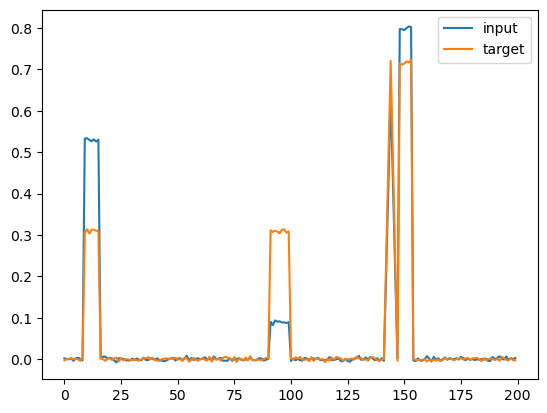

In [94]:
import numpy as np
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Please, set the device according to your setup
DEVICE = "cuda"
SIZE = 200

np.random.seed(39)


def norm_0_1(X):
    return (X - X.min()) / (X.max() - X.min())

def norm_height(X, max_height):
    #return (X - X.min()) / (X.max() - X.min())
    return X / max_height


def positional_encoding(max_position, d_model, min_freq=1e-4):
    # With sinusoidal positional encoding
    position = np.arange(max_position)
    freqs = min_freq**(2*(np.arange(d_model)//2)/d_model)
    pos_enc = position.reshape(-1,1)*freqs.reshape(1,-1)
    pos_enc[:, ::2] = np.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = np.sin(pos_enc[:, 1::2])
    return pos_enc


def positional_encoding_simple(max_position, d_model, min_freq=1e-4):
    # With sinusoidal positional encoding
    pos_enc = np.expand_dims(np.arange(max_position)/max_position, axis=1)
    return pos_enc


@dataclass
class ShapeLog:
    """
    A class to store the information about the shapes in the image
    """

    shape_type: str
    base_point: int
    width: int
    height: int


def generate_pair(size: int = 100, max_height: int = 50, noise_std: float = 0.3, num_shapes:int = 4, positional_encoding_fn = positional_encoding):
    """
    Generate a pair of images. One with the randomly generated sequence of triangles and/or rectangles
    and the other one with the average hights of the shapes in the first image.

    Args:
        size: The size of the image on the x axis
        max_height: The maximum hight of the shapes

    Returns:
        A tuple of two images. The first one is the image with the shapes and the second one is the image with the average hight of the shapes
    """

    min_height = 5
    base_size_range = [3, 10]

    shape_choices = ["triangle", "rectangle"]
    # shape_choices = ["triangle"]
    #convert_to_bin = lambda decimal: [int(s) for s in str(bin(decimal).replace("0b", "")).zfill(7)]
    shape_logs = []

    input = np.zeros(size)

    def draw(input, shape_log):
        if shape_log.shape_type == "triangle":
            pick_point = (shape_log.base_point + (shape_log.base_point + shape_log.width)) // 2
            input[pick_point] = shape_log.height

            # Computing the triangle's first ramp
            num_points = pick_point - shape_log.base_point
            values = np.linspace(0, shape_log.height, num=num_points, endpoint=False, dtype=int)
            input[shape_log.base_point : (shape_log.base_point + shape_log.width // 2)] = values

            # Computing the triangle's second ramp
            num_points = (shape_log.base_point + shape_log.width) - pick_point
            values = np.linspace(shape_log.height, 0, num=num_points, endpoint=False, dtype=int)
            
            word_size = min(size, shape_log.base_point + shape_log.width) - (
                shape_log.base_point + shape_log.width // 2
            )
            input[
                (shape_log.base_point + shape_log.width // 2) : min(size, shape_log.base_point + shape_log.width)
            ] = values[0:word_size]


        else:
            # Rectangle
            input[shape_log.base_point : (shape_log.base_point + shape_log.width)] = shape_log.height

        return input

    def average_shapelogs(shape_logs):
        # Average the two left most and the two right most        
        half_way = len(shape_logs) // 2        
        mean_0 = np.mean([shape_logs[i].height for i in range(half_way)])        
        mean_1 = np.mean([shape_logs[i].height for i in range(half_way,len(shape_logs))])
        
        for i in range(half_way):
            shape_logs[i].height = mean_0

        for i in range(half_way,len(shape_logs)):
            shape_logs[i].height = mean_1

        input_averages = np.zeros(size)
        for shape in shape_logs:
            input_averages = draw(input_averages, shape)

        return input_averages
    
    def remove_overlaps(shape_logs):
        # Removing basic overlaps (it has some flaws, but f*** *t)
        
        for i in range(len(shape_logs)-1):            
            
            # Check overlap
            if shape_logs[i].base_point+shape_logs[i].width > shape_logs[i+1].base_point:
                if i<num_shapes//2:
                    shape_logs[i].base_point -= max(0,shape_logs[i].base_point+shape_logs[i].width)-shape_logs[i+1].base_point-1
                else:
                    shape_logs[i].base_point += min(size,shape_logs[i].base_point+shape_logs[i].width)-shape_logs[i+1].base_point+1
        
        # Treating the last one
        if shape_logs[-1].base_point+shape_logs[-1].width > shape_logs[-2].base_point:
            shape_logs[-1].base_point = min(size,shape_logs[-2].base_point+shape_logs[-2].width)+1

        return shape_logs
            
    
    
    # Picking the middle points
    #base_points = sorted(np.random.uniform(0,100, size=num_shapes).astype("uint"))                
    seeds = [(i*(size//num_shapes), i*(size//num_shapes) + size//num_shapes) for i in range(num_shapes)]    
    base_points = [np.random.randint(mi, ma) for mi,ma in seeds]        
    widths = np.random.randint(base_size_range[0], base_size_range[1], size=num_shapes)
    heights = np.random.randint(min_height, max_height, size=num_shapes)                       
    shapes = np.random.choice(shape_choices, num_shapes)
    
    shape_logs = [
        ShapeLog(shape_type, base_point, width, height)
        for shape_type, base_point, width, height in zip(shapes, base_points, widths, heights)
    ]
    
    shape_logs = remove_overlaps(shape_logs)

    for shape in shape_logs:
        input = draw(input, shape)
                         
    input += np.random.normal(0, noise_std, size)

    target = average_shapelogs(shape_logs) + np.random.normal(0, noise_std, size)

    input = norm_height(input, max_height) 
    target = norm_height(target, max_height)

    
    # Creating the absolute position encoding
    pe = positional_encoding_fn(size, 1).T[0]        
        

    input = np.expand_dims(input, axis=0).astype(np.float32)
    pe = np.expand_dims(pe, axis=0).astype(np.float32)
    target = np.expand_dims(target, axis=0).astype(np.float32)

    return input, target, pe



class ShapeDataset(Dataset):
    def __init__(self, max_samples=1000, size=100, max_height=50, noise_std=0.3, positional_encoding_fn=positional_encoding_simple):
        """
        Shape dataset.
        It generates a pair of images. One with the randomly generated sequence of triangles and/or rectangles
        and the other one with the average hights of the shapes in the first image.

        Args:
            max_samples: The number of samples to generate
            size: The size of the image on the x axis
            max_hight: The maximum hight of the shapes
            noise_std: The standard deviation of the noise to add to the images

        """
        self.images = [generate_pair(size=size, max_height=max_height, noise_std=noise_std, positional_encoding_fn=positional_encoding_fn) for _ in range(max_samples)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx][0], self.images[idx][1], self.images[idx][2]



positional_encoding_fn = positional_encoding_simple
#positional_encoding_fn = positional_encoding
original, target, pe = generate_pair(max_height=100, size=SIZE, positional_encoding_fn=positional_encoding_fn)

# Plotting the dataset
fig = plt.figure()
#pe = positional_encoding_fn(SIZE, 1).T[0]
plt.plot(range(len(original[0])), original[0], label="input")
plt.plot(range(len(target[0])), target[0], label="target")
plt.legend()    


## Training the models

In this example, I'm using the standard positional encoding from the Transformer architecture. The positional encoding is a tensor of shape (1, seq_len, d_model) where seq_len is the length of the sequence and d_model is the dimension of the model. The positional encoding is added to the input tensor before the first layer of the model.

As we can see, positional encoding has a better convergency than vanilla self attention.

Training with attention model WITH NO positional encoding
Epoch: 0, Loss: 0.00327702215872705
Epoch: 10, Loss: 0.0017539019463583827
Epoch: 20, Loss: 0.0009535233257338405
Training with attention model WITH positional encoding
Epoch: 0, Loss: 0.0036442559212446213
Epoch: 10, Loss: 0.0004919430357404053
Epoch: 20, Loss: 0.00024049855710472912


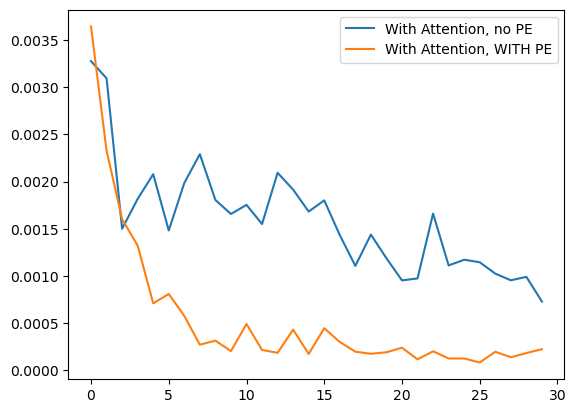

In [95]:
import math
class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

# Implementation of the self attention layer
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, key_dim):
        super().__init__()
        self.conv_Q = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        self.conv_K = nn.Conv1d(in_dim, key_dim, kernel_size=1, bias=False)
        self.conv_V = nn.Conv1d(in_dim, out_dim, kernel_size=1, bias=False)

    def forward(self, x):
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        V = self.conv_V(x)
        A = (Q.transpose(1, 2) @ K) / np.sqrt(K.shape[1])
        A = F.softmax(A, dim=2)        
        y = (A@(V.transpose(1, 2))).transpose(1, 2)
        return y
    
    def forward_attention(self, x):
        Q = self.conv_Q(x)
        K = self.conv_K(x)        
        A = F.softmax(Q.transpose(1, 2)@K, 2)
        return A
    
def train_model(model, epochs=20, device="cuda", positional_encoding_fn=positional_encoding):
    train_loader = torch.utils.data.DataLoader(
        dataset=ShapeDataset(size=100, max_height=50, noise_std=0.3, max_samples=10000, positional_encoding_fn=positional_encoding_fn),
        batch_size=32,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )

    model.train()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    loss_per_epoch = []    
    for epoch in range(epochs):
        for i, (input, target, pe) in enumerate(train_loader):
            input = input.to(device)
            target = target.to(device)
            pe = pe.to(device)
            optimizer.zero_grad()
            output = model([input, pe])
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        if epoch%10==0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")
        loss_per_epoch.append(loss.item())

    return loss_per_epoch



class ModelWithNOPE(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=(5,), padding="same"),
            NewGELU(),
            nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
            NewGELU(),
            SelfAttentionLayer(in_dim=64, out_dim=64, key_dim=64),
            nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
            NewGELU(),
            nn.Conv1d(64, 1, kernel_size=(5,), padding="same"),
        )
    
    def forward(self, x):
        data, _ = x
        return self.model(data)

    
    def __iter__(self):
        return iter(self.model)




class ModelWithPE(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=(5,), padding="same")

        self.conv1_pe = nn.Conv1d(1, 64, kernel_size=(5,), padding="same")

        self.conv2_no_pe = nn.Sequential(    
            NewGELU(),
            nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
            NewGELU(),
            SelfAttentionLayer(in_dim=64, out_dim=64, key_dim=64),
            nn.Conv1d(64, 64, kernel_size=(5,), padding="same"),
            NewGELU(),
            nn.Conv1d(64, 1, kernel_size=(5,), padding="same")
        )

    def forward(self, x):
        data, pe = x

        data = self.conv1(data)
        pe = self.conv1_pe(pe)

        return self.conv2_no_pe(data + pe)

    def __iter__(self):
        return iter(self.conv2_no_pe)

        

# Training with self attention
print("Training with attention model WITH NO positional encoding")
attention_model = ModelWithNOPE()
loss_per_epoch_attention = train_model(attention_model, epochs=30, device=DEVICE)


print("Training with attention model WITH positional encoding")
attention_model_pe = ModelWithPE()
loss_per_epoch_attention_pe = train_model(attention_model_pe, epochs=30, device=DEVICE, positional_encoding_fn=positional_encoding_fn)



plt.figure()
plt.plot(loss_per_epoch_attention, label="With Attention, no PE")
plt.plot(loss_per_epoch_attention_pe, label="With Attention, WITH PE")
plt.legend()


## Visualizations

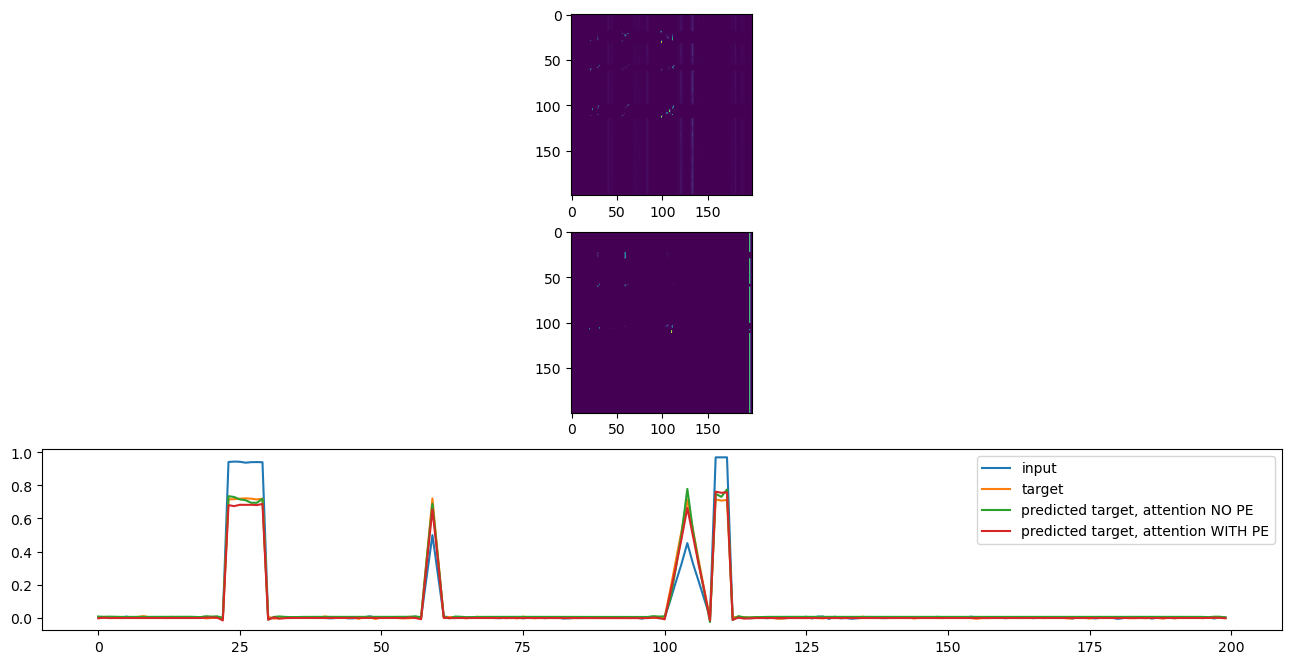

In [96]:
np.random.seed(1000)
input, target, pe = generate_pair(max_height=100, size=SIZE, positional_encoding_fn=positional_encoding_fn)

input = np.expand_dims(input, axis=0)
target = np.expand_dims(target, axis=0)

attention_model.eval()
attention_model_pe.eval()

input = torch.tensor(input)
pe = torch.tensor(pe)

input = input.to(DEVICE)
pe = pe.to(DEVICE)

input_tensor = [input, pe]

def extract_attention(model, input_tensor, with_pe=False):
    # It is a little bit improvised, but it is for educational purposes
    attention = []
    if with_pe:
        x = input_tensor[0]
        pe = input_tensor[1]

        x = model.conv1(x)
        pe = model.conv1_pe(pe)

        x = x + pe

    else:
        x = input_tensor[0]

    for layer in model:
        if isinstance(layer, SelfAttentionLayer):
            attention.append(layer.forward_attention(x))        
        x = layer(x)
    return attention


attention = extract_attention(attention_model, input_tensor)[0]
attention = attention.detach().to("cpu").numpy()[0]
predicted = attention_model(input_tensor)[0][0].detach().to("cpu").numpy()


attention_pe = extract_attention(attention_model_pe, input_tensor, with_pe=True)[0]
attention_pe = attention_pe.detach().to("cpu").numpy()[0]
predicted_pe = attention_model_pe(input_tensor)[0][0].detach().to("cpu").numpy()

input = input.detach().to("cpu").numpy()
#target = target.detach().to("cpu").numpy()
#print(input[0][0])

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(16,8))
ax1.imshow(attention)
ax2.imshow(attention_pe)
ax3.plot(range(len(input[0][0])), input[0][0], label="input")
ax3.plot(range(len(target[0][0])), target[0][0], label="target")
ax3.plot(range(len(predicted)), predicted, label="predicted target, attention NO PE")
ax3.plot(range(len(predicted_pe)), predicted_pe, label="predicted target, attention WITH PE")
plt.legend()
